In [1]:
%matplotlib inline


Cueing Group Analysis
===============================

This notebook is slightly different than the PC notebooks due to differences in the Mac operating system.

First setup the computer by following the instructions in the mac_instructions_cueing.docx file, then return to this file.

The cueing task can ellicit a number of reliable changes. A central cue indicates the location of an upcoming target onset. Here the task can be changed to be perfectly predictive, or have some level of cue validity. Task is to indicate the orientation of a spatial grating on the target, up for vertical, right for horizontal.

ERP - Validly cued targets ellict larger ERP's than invalidly cued targets

Response ERPs - Validly cued targets are more quickly identified and better identified

Oscillations - Alpha power lateralizes after a spatial cue onset preceeding the upcoming onset of a target. Alpha power becomes smaller contraleral to the target side, and larger ipsilateral with the target.


In [3]:
# Imports
from mne import Epochs, find_events, concatenate_raws
from mne.time_frequency import tfr_morlet
import numpy as np
import os
#from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import matplotlib.patches as patches

from eegnb.datasets import datasets
from eegnb.analysis import utils

Download the data
-----------------------------



In [4]:
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')
cueing_data_path = os.path.join(eegnb_data_path, 'visual-cueing', 'kylemathlab_dev')

# If dataset hasn't been downloaded yet, download it
if not os.path.isdir(cueing_data_path):
      datasets.fetch_dataset(data_dir=eegnb_data_path, experiment='visual-cueing', site='kylemathlab_dev')

Load data into MNE objects
-----------------------------



In [5]:
# MNE is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

# The first step after loading dependencies is use MNE to read the data we've collected into an MNE Raw object

101
Creating RawArray with float64 data, n_channels=5, n_times=61284
    Range : 0 ... 61283 =      0.000 ...   239.387 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=61284
    Range : 0 ... 61283 =      0.000 ...   239.387 secs
Ready.
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 30 Hz
Using filter length: 61284

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

122 events found
Event IDs: [ 1  2 11 12 21 22]
Trials Remaining: 10.
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

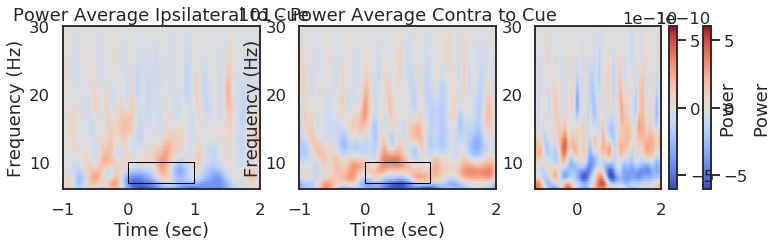

In [7]:
subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
        202, 203, 204, 205, 207, 208, 209, 210, 211, 
        301, 302, 303, 304, 305, 306, 307, 308, 309]

diff_out = []
Ipsi_out = []
Contra_out = []
Ipsi_spectra_out = []
Contra_spectra_out = []
diff_spectra_out = []
ERSP_diff_out = []
ERSP_Ipsi_out = []
ERSP_Contra_out = []

frequencies =  np.linspace(6, 30, 100, endpoint=True)
wave_cycles = 6

# time frequency window for analysis
f_low = 7 # Hz
f_high = 10
f_diff = f_high-f_low
 
t_low = 0 # s
t_high = 1
t_diff = t_high-t_low

bad_subs= [6, 7, 13, 26]
really_bad_subs = [11, 12, 19]
sub_count = 0    
    
    
    
for sub in subs:
    print(sub)
    
    sub_count += 1

    
    if (sub_count in really_bad_subs):
        rej_thresh_uV = 90
    elif (sub_count in bad_subs):
        rej_thresh_uV = 90
    else:
        rej_thresh_uV = 90

    rej_thresh = rej_thresh_uV*1e-6
    

    
    # Load both sessions
    raw = utils.load_data(cueing_data_path, sfreq=256., 
                          subject_nb=sub, session_nb=1)
    raw.append(    utils.load_data(cueing_data_path, sfreq=256., 
                          subject_nb=sub, session_nb=2)           )

    # Filter Raw Data
    raw.filter(1,30, method='iir')

    #Select Events
    events = find_events(raw)
    event_id = {'LeftCue': 1, 'RightCue': 2}
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=-1, tmax=2, baseline=(-1, 0), 
                    reject={'eeg':rej_thresh}, preload=True,
                    verbose=False, picks=[0, 3])
    print('Trials Remaining: ' + str(len(epochs.events)) + '.')

    # Compute morlet wavelet

    # Left Cue
    tfr, itc = tfr_morlet(epochs['LeftCue'], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=True)
    tfr = tfr.apply_baseline([-1,-.5],mode='mean')
    #tfr.plot(picks=[0], mode='logratio', 
    #         title='TP9 - Ipsi');
    #tfr.plot(picks=[3], mode='logratio', 
    #         title='TP10 - Contra');
    power_Ipsi_TP9 = tfr.data[0,:,:]
    power_Contra_TP10 = tfr.data[1,:,:]

    # Right Cue
    tfr, itc = tfr_morlet(epochs['RightCue'], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=True)
    tfr = tfr.apply_baseline([-1,-.5],mode='mean')
    #tfr.plot(picks=[0], mode='logratio', 
    #         title='TP9 - Contra');
    #tfr.plot(picks=[3], mode='logratio', 
    #         title='TP10 - Ipsi');
    power_Contra_TP9 = tfr.data[0,:,:]
    power_Ipsi_TP10 = tfr.data[1,:,:]

    # Plot Differences
    #%matplotlib inline
    times = epochs.times
    power_Avg_Ipsi =   (power_Ipsi_TP9+power_Ipsi_TP10)/2;
    power_Avg_Contra = (power_Contra_TP9+power_Contra_TP10)/2;
    power_Avg_Diff = power_Avg_Ipsi-power_Avg_Contra;


    #find max to make color range
    plot_max = np.max([np.max(np.abs(power_Avg_Ipsi)), np.max(np.abs(power_Avg_Contra))])
    plot_diff_max = np.max(np.abs(power_Avg_Diff))

   
    fig, axs = plt.subplots(ncols=3, figsize=(12,3))
    
    #Ipsi
    ax = axs[0]
    im = ax.imshow(power_Avg_Ipsi,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
    #im = plt.imshow(power_Avg_Ipsi,
    #           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
    #           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title('Power Average Ipsilateral to Cue')
    cb = fig.colorbar(im)
    cb.set_label('Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    #TP10
    #fig, ax = plt.subplots(1)
    ax = axs[1]
    im = ax.imshow(power_Avg_Contra,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(str(sub) + ' - Power Average Contra to Cue')
    cb = fig.colorbar(im)
    cb.set_label('Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    #difference between conditions
    #fig, ax = plt.subplots(1)
    ax = axs[2]
    im = ax.imshow(power_Avg_Diff,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_diff_max, vmax=plot_diff_max)
    ax.xlabel('Time (sec)')
    ax.ylabel('Frequency (Hz)')
    ax.title('Power Difference Ipsi-Contra')
    cb = fig.colorbar(im)
    cb.set_label('Ipsi-Contra Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
     
        
    plt.tight_layout()
        
    #output data into array
    Ipsi_out.append(np.mean(power_Avg_Ipsi[np.argmax(frequencies>f_low):
                                           np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]
                           )
                   )            
    Ipsi_spectra_out.append(np.mean(power_Avg_Ipsi[:,np.argmax(times>t_low):
                                                   np.argmax(times>t_high)-1 ],1
                                   )
                           )
        
    Contra_out.append(np.mean(power_Avg_Contra[np.argmax(frequencies>f_low):
                                               np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]
                             )
                     )
    
    Contra_spectra_out.append(np.mean(power_Avg_Contra[:,np.argmax(times>t_low):
                                                       np.argmax(times>t_high)-1 ],1))
    
    
    diff_out.append(np.mean(power_Avg_Diff[np.argmax(frequencies>f_low):
                                           np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]
                           )
                   )
    diff_spectra_out.append(np.mean(power_Avg_Diff[:,np.argmax(times>t_low):
                                                   np.argmax(times>t_high)-1 ],1
                                   )
                           )
    
    
    ERSP_diff_out.append(power_Avg_Diff)
    ERSP_Ipsi_out.append(power_Avg_Ipsi)
    ERSP_Contra_out.append(power_Avg_Contra)


    
print(np.shape(ERSP_diff_out))
print(np.shape(Contra_spectra_out))

print(diff_out)

In [12]:
import seaborn as sns

In [17]:
times.shape

(769,)

In [19]:
import pandas as pd

In [64]:
df = pd.DataFrame(np.flipud(power_Avg_Contra),columns=np.round(times,3),
                  index=np.round(frequencies,2))

In [70]:
nr,nc = df.shape

In [73]:
idxs_r = np.arange(0, nr,10)
idxs_c = np.arange(0, nc,10)


In [78]:
idxs_c

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
       520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640,
       650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760])

In [76]:
df.columns.shape

(769,)

In [82]:
import matplotlib.ticker as ticker


In [95]:
frequencies[-1]

30.0

In [94]:
times[-1]

2.0

In [109]:
sns.heatmap?

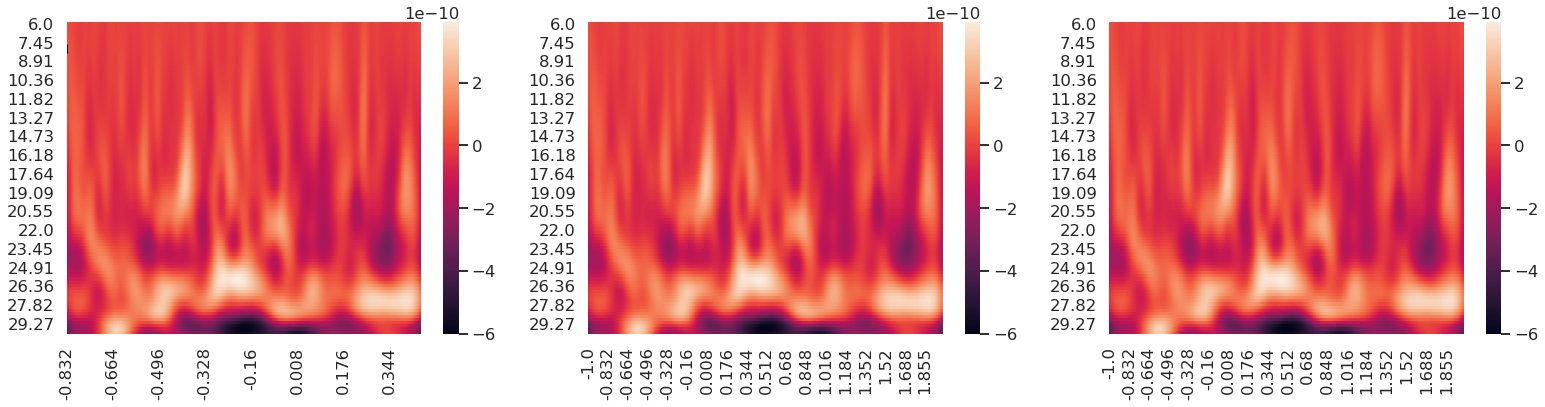

In [111]:
fig,ax = plt.subplots(ncols=3, figsize=(22,6))

sns.heatmap(df,ax=ax[0])#,xticklabels=df.columns[idxs_c],yticklabels=df.index[idxs_r])
plt.xticks(rotation=0)
sns.heatmap(df,ax=ax[1])
sns.heatmap(df,ax=ax[2])

ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))

#ax[0].xticks(rotation=0) 

#ax[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))
#ax[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
#ax[2].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax[0].add_patch(rect)


plt.tight_layout()

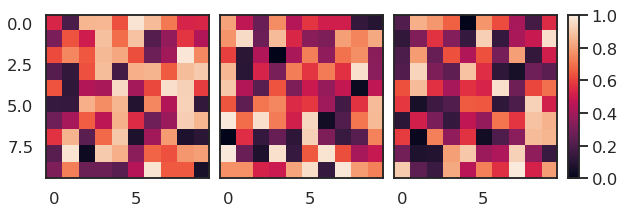

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
for ax in grid:
    im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)

# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

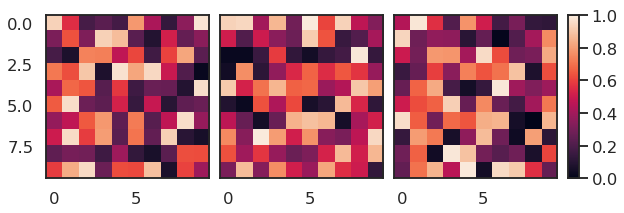

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
for ax in grid:
    im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)

    # Colorbar
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

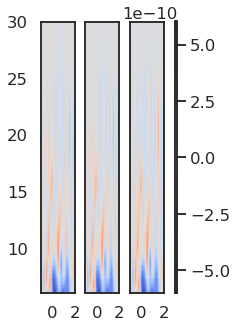

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(100, 5))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
for ax in grid:
    
    ax.imshow(power_Avg_Ipsi,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)

    #im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)

    # Colorbar
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

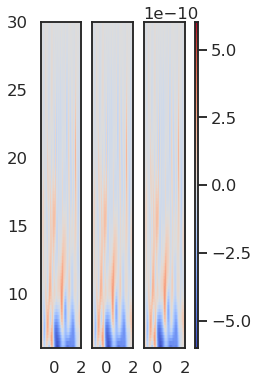

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(12, 6))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
for ax in grid:
    im = ax.imshow(power_Avg_Ipsi,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)

#ax = grid[1]
#im = ax.imshow(power_Avg_Ipsi,
#               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
#               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)

#ax = grid[2]
#im = ax.imshow(power_Avg_Ipsi,
#               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
#               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)



# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)



#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

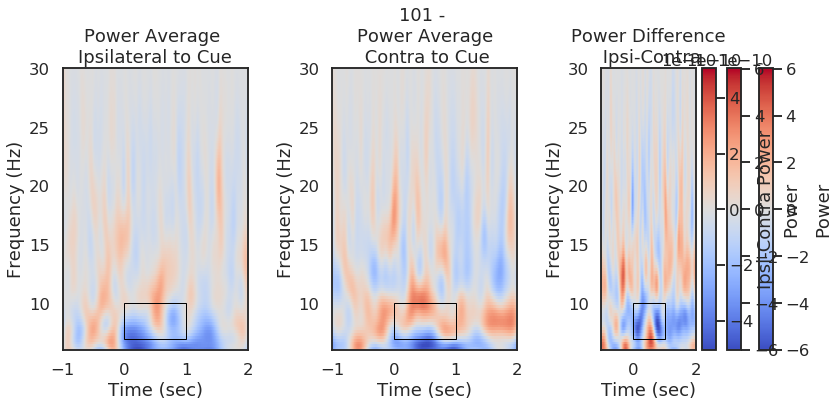

In [112]:
fig, axs = plt.subplots(ncols=3, figsize=(12,6))
    

#Ipsi
ax = axs[0]
im = ax.imshow(power_Avg_Ipsi,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)

#im = plt.imshow(power_Avg_Ipsi,

#           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],

#           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)

ax.set_xlabel('Time (sec)')


ax.set_ylabel('Frequency (Hz)')

ax.set_title('Power Average \nIpsilateral to Cue')

cb = fig.colorbar(im)

cb.set_label('Power')

# Create a Rectangle patch

rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')

# Add the patch to the Axes

ax.add_patch(rect)


#TP10

#fig, ax = plt.subplots(1)

ax = axs[1]

im = ax.imshow(power_Avg_Contra,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)

ax.set_xlabel('Time (sec)')

ax.set_ylabel('Frequency (Hz)')

ax.set_title(str(sub) + ' - \nPower Average\n Contra to Cue')

cb = fig.colorbar(im)

cb.set_label('Power')

# Create a Rectangle patch

rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')

# Add the patch to the Axes

ax.add_patch(rect)


#difference between conditions

#fig, ax = plt.subplots(1)

ax = axs[2]

im = ax.imshow(power_Avg_Diff,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_diff_max, vmax=plot_diff_max)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('Power Difference\n Ipsi-Contra')
#cb = fig.colorbar(im)
#cb.set_label('Ipsi-Contra Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
     
    

    
plt.tight_layout()


Combine subjects
----------------------------



In [ ]:
GrandAvg_diff = np.nanmean(ERSP_diff_out,0)
GrandAvg_Ipsi = np.nanmean(ERSP_Ipsi_out,0)
GrandAvg_Contra = np.nanmean(ERSP_Contra_out,0)

GrandAvg_spec_Ipsi = np.nanmean(Ipsi_spectra_out,0)
GrandAvg_spec_Contra = np.nanmean(Contra_spectra_out,0)
GrandAvg_spec_diff = np.nanmean(diff_spectra_out,0)

num_good = len(diff_out) - sum(np.isnan(diff_out))   
GrandAvg_spec_Ipsi_ste = np.nanstd(Ipsi_spectra_out,0)/np.sqrt(num_good)
GrandAvg_spec_Contra_ste = np.nanstd(Contra_spectra_out,0)/np.sqrt(num_good)
GrandAvg_spec_diff_ste = np.nanstd(diff_spectra_out,0)/np.sqrt(num_good)

#Spectra error bars
fig, ax = plt.subplots(1)
plt.errorbar(frequencies,GrandAvg_spec_Ipsi,yerr=GrandAvg_spec_Ipsi_ste)
plt.errorbar(frequencies,GrandAvg_spec_Contra,yerr=GrandAvg_spec_Contra_ste)

plt.legend(('Ipsi','Contra'))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (uV^2)')   
plt.hlines(0,3,33)

#Spectra Diff error bars
fig, ax = plt.subplots(1)
plt.errorbar(frequencies,GrandAvg_spec_diff,yerr=GrandAvg_spec_diff_ste)

plt.legend('Ipsi-Contra')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (uV^2)')   
plt.hlines(0,3,33)

#Grand Average Ipsi
plot_max = np.max([np.max(np.abs(GrandAvg_Ipsi)), np.max(np.abs(GrandAvg_Contra))])  
fig, ax = plt.subplots(1)
im = plt.imshow(GrandAvg_Ipsi,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Ipsi')
cb = fig.colorbar(im)
cb.set_label('Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

#Grand Average Contra
fig, ax = plt.subplots(1)
im = plt.imshow(GrandAvg_Contra,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Contra')
cb = fig.colorbar(im)
cb.set_label('Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

#Grand Average Ipsi-Contra Difference
plot_max_diff = np.max(np.abs(GrandAvg_diff))
fig, ax = plt.subplots(1)
im = plt.imshow(GrandAvg_diff,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max_diff, vmax=plot_max_diff)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Difference Ipsi-Contra')
cb = fig.colorbar(im)
cb.set_label('Ipsi-Contra Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

Compute t test
----------------------------



In [ ]:
import scipy
num_good = len(diff_out) - sum(np.isnan(diff_out))

[tstat, pval] = scipy.stats.ttest_ind(diff_out,np.zeros(len(diff_out)),nan_policy='omit')
print('Ipsi Mean: '+  str(np.nanmean(Ipsi_out))) 
print('Contra Mean: '+  str(np.nanmean(Contra_out))) 
print('Mean Diff: '+  str(np.nanmean(diff_out))) 
print('t(' + str(num_good-1) + ') = ' + str(round(tstat,3)))
print('p = ' + str(round(pval,3)))

Save average powers ipsi and contra
----------------------------



In [ ]:
import pandas as pd
print(diff_out)
raw_data = {'Ipsi Power': Ipsi_out, 
        'Contra Power': Contra_out}
df = pd.DataFrame(raw_data, columns = ['Ipsi Power', 'Contra Power'])
df.to_csv('375CueingEEG.csv')
print('Saved subject averages for each condition to 375CueingEEG.csv file in present directory')

Save spectra
----------------------------



In [ ]:
df = pd.DataFrame(Ipsi_spectra_out,columns=frequencies)
df.to_csv('375CueingIpsiSpec.csv')

df = pd.DataFrame(Contra_spectra_out,columns=frequencies)
df.to_csv('375CueingContraSpec.csv')
print('Saved Spectra to 375Cueing*Spec.csv file in present directory')

Conclusions
----------------------------



In [ ]:
# Blah